# 1. Inverse CDF

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import sys
sys.path.append('../examples')
sys.path.append('../jobs')
sys.path.append('../training_data')

from tqdm import trange

import torch
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import gaussian_kde

from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config
from generate_with_calibration import get_lookahead_entropies
from generate_with_entropy import sample_sequence, sample_sequence_batch, top_k_top_p_filtering

import logging
logging.getLogger('transformers.tokenization_utils').setLevel(logging.ERROR)

To use data.metrics please install scikit-learn. See https://scikit-learn.org/stable/index.html


In [2]:
# setup cell

def set_seed(seed=42, n_gpu=0):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpus = torch.cuda.device_count()

set_seed()
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.to(device)
model.eval()

vocab_size = tokenizer.vocab_size

01/10/2020 21:14:22 - INFO - transformers.configuration_utils -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-config.json from cache at /u/myhu/.cache/torch/transformers/4be02c5697d91738003fb1685c9872f284166aa32e061576bbe6aaeb95649fcf.085d5f6a8e7812ea05ff0e6ed0645ab2e75d80387ad55c1ad9806ee70d272f80
01/10/2020 21:14:22 - INFO - transformers.configuration_utils -   Model config {
  "attn_pdrop": 0.1,
  "embd_pdrop": 0.1,
  "finetuning_task": null,
  "initializer_range": 0.02,
  "is_decoder": false,
  "layer_norm_epsilon": 1e-05,
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_layer": 12,
  "n_positions": 1024,
  "num_labels": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pruned_heads": {},
  "resid_pdrop": 0.1,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "torchscript": false,
  "use_bf

In [175]:
# the ground truth

# file = '../training_data/train.wp_h100'
# file = '../training_data/unicorn.txt'
file = '../training_data/gbw/training/news1-head1k'

inv_cdf = []
token_ranks = []
with open(file) as fp:
    for line in fp:
        context = tokenizer.encode(line)
        
        N = len(context)
        
        for i in range(1, N):
            context_i = torch.tensor(context[:i], dtype=torch.long, device=device).unsqueeze(0)
    
            inputs = {'input_ids': context_i}
            outputs = model(**inputs)  
            model_next_logits = outputs[0][:, -1, :]
            
            next_probs = F.softmax(model_next_logits, dim=-1)[0].detach().cpu().numpy()
            sorted_probs = np.sort(next_probs)[::-1]
            
            next_word = context[i]
            ranks = np.argsort(next_probs)[::-1]
            token_rank = np.argwhere(ranks == next_word)[0][0]
            prev_prob = np.sum(sorted_probs[:token_rank + 1])
            
            inv_cdf.append(prev_prob)
            token_ranks.append(token_rank)

In [ ]:
token_ranks

In [54]:
x = []
y = []
for xi, yi in enumerate(token_ranks):
    x.append(np.log(xi + 1e-20))
    y.append(np.log(yi + 1e-20))

Text(0.5, 1.0, 'Empirical Inverse CDF')

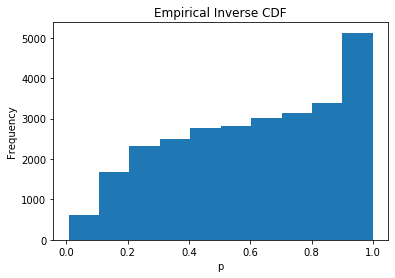

In [178]:
plt.hist(inv_cdf)
plt.xlabel('p')
plt.ylabel('Frequency')
plt.title('Empirical Inverse CDF')

(array([2.6787e+04, 3.1700e+02, 1.4300e+02, 7.4000e+01, 3.3000e+01,
        2.2000e+01, 1.1000e+01, 1.1000e+01, 3.0000e+00, 3.0000e+00]),
 array([    0. ,  4053.2,  8106.4, 12159.6, 16212.8, 20266. , 24319.2,
        28372.4, 32425.6, 36478.8, 40532. ]),
 <a list of 10 Patch objects>)

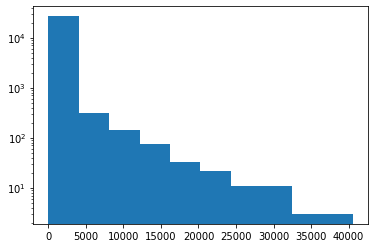

In [57]:
plt.hist(token_ranks, log=True)

In [60]:
def get_counts(file, length=100, num_samples=1, temperature=1, top_k=0, top_p=0.0):
    ret = []
    with open(file) as fp:
        for line in fp:
            context = tokenizer.encode(line)
            context = torch.tensor(context, dtype=torch.long, device=device)
            context = context.unsqueeze(0).repeat(num_samples, 1)
            generated = context

            with torch.no_grad():

                for gen_index in trange(length):

                    inputs = {'input_ids': generated}

                    outputs = model(**inputs)
                    next_token_logits = outputs[0][:, -1, :] / temperature
                    next_probs = F.softmax(next_token_logits, dim=-1)[0].detach().cpu().numpy()

                    filtered_logits = top_k_top_p_filtering(next_token_logits, top_k=top_k, top_p=top_p)
                    next_token = torch.multinomial(F.softmax(filtered_logits, dim=-1), num_samples=1)
                    rank = np.argsort(next_probs)[::-1]
                    ret.append(np.argwhere(rank == next_token.item())[0][0]) # grossly inefficient but idc anymore

                    generated = torch.cat((generated, next_token), dim=1)
    return ret

In [61]:
file = '../training_data/gbw/training/news1-head100'
calibrated_temp_counts = get_counts(file, temperature=0.968)

100%|██████████| 100/100 [00:02<00:00, 46.65it/s]


In [42]:
yeet = test.resample(size=100)

(array([23., 16.,  4.,  4.,  7.,  7., 11.,  5., 10., 13.]),
 array([-0.08541767,  0.02607871,  0.13757508,  0.24907146,  0.36056784,
         0.47206422,  0.5835606 ,  0.69505698,  0.80655336,  0.91804974,
         1.02954612]),
 <a list of 10 Patch objects>)

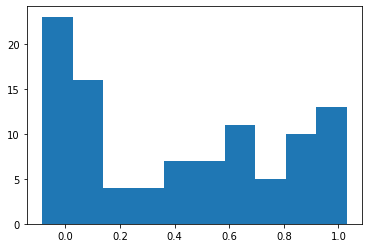

In [43]:
plt.hist(yeet[0])

In [46]:
yeet[0]

array([ 0.6167773 , -0.02634005,  0.06288728,  0.1403665 ,  0.5082095 ,
        0.7257506 ,  0.01780686, -0.03638509,  0.55196207,  0.83470043,
        0.90546569,  0.64649231,  0.20783778,  0.09517658,  0.05331925,
        0.42877569,  0.01541445, -0.01880571,  0.90822012, -0.01974999,
        0.01801012, -0.01922155,  0.89315798,  0.09475982,  0.93201274,
       -0.01488577,  0.0548457 ,  0.37174643,  0.45669559,  0.17635546,
       -0.08541767,  0.58578857,  0.65293729,  0.85498646,  1.01450289,
        0.95401274,  1.00889553,  0.58400763,  0.10797469,  0.34730276,
        0.62705767,  0.49494964,  0.96693654, -0.01896145,  0.02889191,
        0.10367658,  0.82346355,  0.0113334 ,  0.41887621, -0.03880267,
        0.03791194, -0.03908756,  0.72345343, -0.02180915,  0.27289542,
        0.25831896,  0.04737258,  0.84632256, -0.0123221 ,  0.94049572,
       -0.02028579,  0.99708784,  0.61877842,  0.69147048,  0.67336837,
        1.02954612,  0.98891752,  0.41666278,  0.73206897,  0.60

In [ ]:
from scipy.stats import zipf

In [177]:
np.savez('inv_cdf_2', inv_cdf=inv_cdf, token_ranks=token_ranks)

# 2. MLE parameter

In [3]:
from scipy.special import zeta
from scipy.stats import zipf
from scipy.optimize import minimize_scalar

In [4]:
def mle(alpha, x):
    N = len(x)
    return alpha * np.sum(np.log(x + 1)) + N * np.log(zeta(alpha, 1) - zeta(alpha, 50258))

In [64]:
token_ranks = np.array(token_ranks)

In [74]:
minimize_scalar(lambda alpha: mle(alpha, token_ranks))

/n/fs/pnlp/myhu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


     fun: 124379.60550690646
    nfev: 15
     nit: 11
 success: True
       x: 1.2933939167616206

In [27]:
def zipf_pmf(k, alpha, vocab_size):
    return ((k + 1) ** -alpha) / (zeta(alpha, 1) - zeta(alpha, vocab_size + 1))

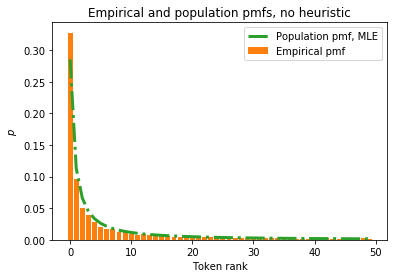

In [54]:
# empirical pmf

true_pmf = zipf_pmf(x, 1.3354, 50257)
true_pmf = true_pmf / np.sum(true_pmf)
empirical_pmf = get_empirical_distribution(full)

plt.bar(x[:50], empirical_pmf[:50], label='Empirical pmf', color='C1')
plt.plot(x[:50], true_pmf[:50], label='Population pmf, MLE', ls='-.', color='C2', lw=3)
plt.xlabel('Token rank')
plt.ylabel('$p$')
plt.title('Empirical and population pmfs, no heuristic')
plt.legend()

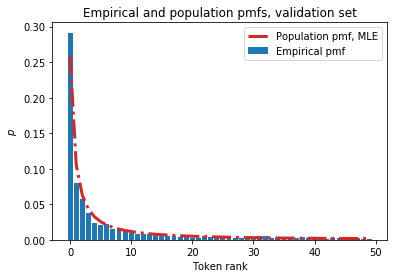

In [51]:
true_pmf = zipf_pmf(x, 1.29339, 50257)
true_pmf = true_pmf / np.sum(true_pmf)
gt = data['ground_truth']
empirical_pmf = get_empirical_distribution(gt)

plt.bar(x[:50], empirical_pmf[:50], label='Empirical pmf', color='C0')
plt.plot(x[:50], true_pmf[:50], label='Population pmf, MLE', ls='-.', color='C3', lw=3)
plt.xlabel('Token rank')
plt.ylabel('$p$')
plt.title('Empirical and population pmfs, validation set')
plt.legend()

In [41]:
empirical_pmf[:10]

array([0.3275, 0.0963, 0.0501, 0.0387, 0.0282, 0.0204, 0.0174, 0.0163,
       0.0125, 0.0122])

In [13]:
x = np.arange(50257)
true_pmf = zipf_pmf(x, 1.29339, 0, 50257)
true_pmf = true_pmf / np.sum(true_pmf)

In [36]:
# load data

data = np.load('cache.npz')
top_k = data['top_k']
greedy = data['greedy']
full = data['full']
temp = data['temp']

In [28]:
# taking the cross entropy losses:

def CEL(empirical_pmf, true_pmf):
    # empirical_pmf = get_empirical_distribution(counts)
    return np.dot(true_pmf, -np.log(empirical_pmf + 1e-20))

def get_empirical_distribution(counts):
    freqs = np.zeros(vocab_size)
    for i in counts:
        freqs[i] += 1
    return freqs / np.sum(freqs)

def truncate_distribution(distr, k):
    mass = np.sum(distr[k:])
    top_k = distr[:k]
    top_k = top_k + mass * top_k / np.sum(top_k)
    return np.concatenate((top_k, np.zeros(distr[k:].shape)), axis=None)

In [122]:
CEL(top_k, true_pmf)

13.92766651477528

In [123]:
CEL(greedy, true_pmf)

34.13437822451482

In [115]:
CEL(full, true_pmf)

7.712297159966158

In [116]:
CEL(temp, true_pmf)

7.685716492317358

In [64]:
CEL(true_pmf, true_pmf)

4.1997827164516375

In [7]:
minimize_scalar(lambda alpha: mle(alpha, full))

/n/fs/pnlp/myhu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


     fun: 41996.653198138076
    nfev: 16
     nit: 12
 success: True
       x: 1.3354152576441611

In [10]:
x = np.arange(50257)
alpha = 1.3354
full_pmf = zipf_pmf(x, alpha, 0, 50257)
full_pmf = full_pmf / np.sum(full_pmf)

Text(0.5, 1.0, 'Top-$k$ sampling, $k=40$')

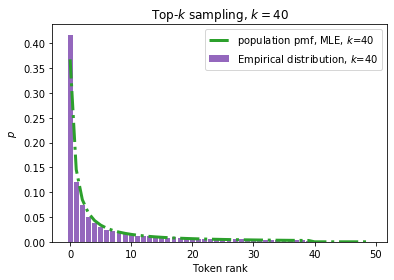

In [59]:
truncated_pmf = truncate_distribution(true_pmf, 40)

topk_pmf = get_empirical_distribution(top_k)
plt.bar(x[:50], topk_pmf[:50], label='Empirical distribution, $k$=40', color='C4')
plt.plot(x[:50], truncated_pmf[:50], label='population pmf, MLE, $k$=40', ls='-.', color='C2', lw=3)
plt.xlabel('Token rank')
plt.ylabel('$p$')
plt.legend()
plt.title('Top-$k$ sampling, $k=40$')

Text(0.5, 1.0, 'Greedy decoding')

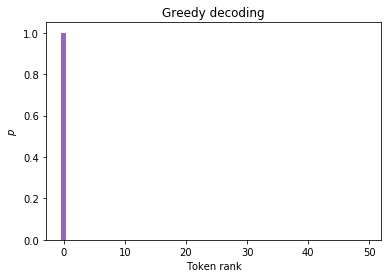

In [45]:
greedy_pmf = get_empirical_distribution(greedy)
plt.bar(x[:50], greedy_pmf[:50], color='C4')
plt.xlabel('Token rank')
plt.ylabel('$p$')
plt.title('Greedy decoding')

Text(0.5, 1.0, 'Temperature scaling, $T=0.8$')

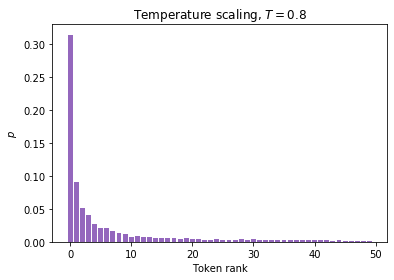

In [46]:
temp_pmf = get_empirical_distribution(temp)
plt.bar(x[:50], temp_pmf[:50], color='C4')
plt.xlabel('Token rank')
plt.ylabel('$p$')
plt.title('Temperature scaling, $T=0.8$')

In [137]:
top_k = truncate_distribution(full_pmf, 40)
CEL(top_k, true_pmf)

13.919730963155779

In [139]:
vals = np.zeros(vocab_size + 1)
for i in range(1, vocab_size + 1):
    top_k = truncate_distribution(full_pmf, i)
    vals[i] = CEL(top_k, true_pmf)

Text(0.5, 1.0, 'CEL is monotonically decreasing over $k$')

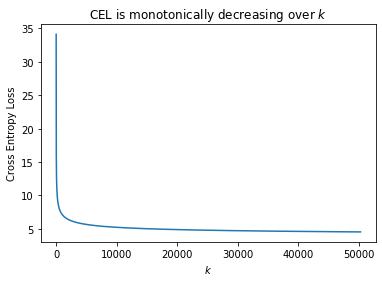

In [192]:
plt.plot(vals[1:])
plt.ylabel('Cross Entropy Loss')
plt.xlabel('$k$')
plt.title('CEL is monotonically decreasing over $k$')

In [155]:
def minimize_k(true_pmf, full_pmf, vocab_size, threshold=1e-3):
    last_loss = float('inf')
    min_k = 0
    for i in range(1, vocab_size + 1):
        top_k = truncate_distribution(full_pmf, i)
        loss = CEL(top_k, true_pmf)
        if abs(last_loss - loss) < threshold:
            print(f'MIN INDEX {i}')
            min_k = i
            break
        if i % 1000 == 999:
            print(f'LOSS: {loss}. ITER: {i}')
        last_loss = loss
    return min_k

In [157]:
minimize_k(true_pmf, full_pmf, vocab_size, threshold=1e-2)

MIN INDEX 202


202

In [193]:
minimize_k(true_pmf, full_pmf, vocab_size, threshold=1e-1)

MIN INDEX 36


36

In [11]:
def CEL_temp(true_pmf, full_pmf, t):
    scaled_pmf = temp_scaling(t, full_pmf)
    return CEL(scaled_pmf, true_pmf)

def temp_scaling(t, full_pmf):
    logits = np.log(full_pmf) / t
    return np.exp(logits) / np.sum(np.exp(logits))

In [14]:
minimize_scalar(lambda temp: CEL_temp(full_pmf, true_pmf, temp))

/n/fs/pnlp/myhu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/n/fs/pnlp/myhu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


     fun: 4.199782716451639
    nfev: 15
     nit: 11
 success: True
       x: 0.9685412614964904

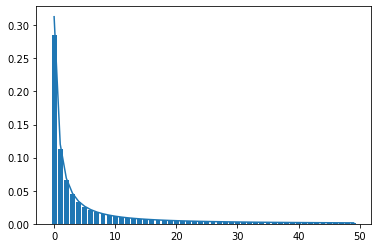

In [22]:
scaled = temp_scaling(0.968, full_pmf)
plt.bar(x[:50], full_pmf[:50])
plt.plot(x[:50], scaled[:50])

In [19]:
full_pmf[-10:]

array([1.50526366e-07, 1.50522366e-07, 1.50518365e-07, 1.50514365e-07,
       1.50510366e-07, 1.50506366e-07, 1.50502367e-07, 1.50498367e-07,
       1.50494368e-07, 1.50490370e-07])

In [18]:
scaled[-10:]

array([1.02339637e-07, 1.02336828e-07, 1.02334018e-07, 1.02331209e-07,
       1.02328400e-07, 1.02325591e-07, 1.02322782e-07, 1.02319973e-07,
       1.02317164e-07, 1.02314355e-07])

In [170]:
# proving that my procedure properly scales the logits, the dumb way

test = np.array([1,2,3])
probs = np.exp(test) / np.sum(np.exp(test))

In [171]:
probs

array([0.09003057, 0.24472847, 0.66524096])

In [172]:
np.log(probs)

array([-2.40760596, -1.40760596, -0.40760596])

In [173]:
scaled = test / 0.8
scaled_probs = np.exp(scaled) / np.sum(np.exp(scaled))
scaled_probs

array([0.0599778 , 0.20934308, 0.73067913])

In [174]:
scaled_2 = np.log(probs) / 0.8
scaled_probs_2 = np.exp(scaled_2) / np.sum(np.exp(scaled_2))
scaled_probs_2

array([0.0599778 , 0.20934308, 0.73067913])

In [24]:
inv_cdf = np.load('011020_inv_cdf_token_ranks.npz')['ranks']

In [29]:
emp_inv_cdf = get_empirical_distribution(inv_cdf)

In [30]:
CEL(emp_inv_cdf, true_pmf)

7.694310510475514

In [62]:
emp_distr = get_empirical_distribution(calibrated_temp_counts)
CEL(emp_distr, true_pmf)

6.886748274635498